In [32]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

import lmfit
from scipy.integrate import odeint

In [33]:
covid_stats=pd.read_csv("../../covid-statistics-by-us-states-daily-updates.csv")
covid_stats=covid_stats[covid_stats.state=='NY']
covid_stats=covid_stats.drop(['Unnamed: 0', 'posneg', 'pending', 'hash','commercialscore', 'negativeregularscore',
                             'negativescore', 'positivescore', 'grade', 'score','state','dataqualitygrade',
                              'lastupdateet', 'datemodified','checktimeet', 'datechecked', 'fips', 'hash',
                              'commercialscore','negativeregularscore', 'negativescore', 'positivescore',
                              'score', 'grade','onventilatorcumulative','deathconfirmed','deathprobable',
                             'inicucumulative','negativetestsviral','positivetestsviral', 'totaltestsviral',
                              'positivecasesviral'], 
                             axis=1).sort_values('date')
covid_stats = covid_stats.fillna(0)
covid_stats

,date,positive,negative,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,onventilatorcurrently,recovered,death,hospitalized,positiveincrease,negativeincrease,total,totaltestresults,totaltestresultsincrease,deathincrease,hospitalizedincrease
8138,2020-03-04,6.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,78,54,0,0,0
8120,2020-03-05,22.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,28,122,98,44,0,0
8093,2020-03-06,33.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,16,361,125,27,0,0
8053,2020-03-07,76.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43,0,404,168,43,0,0
8003,2020-03-08,105.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,0,197,197,29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2020-07-25,411200.0,5105111.0,646.0,89995.0,149.0,94.0,72632.0,25103.0,89995.0,750,70716,5516311,5516311,71466,13,0
205,2020-07-26,411736.0,5158143.0,637.0,89995.0,155.0,90.0,72716.0,25106.0,89995.0,536,53032,5569879,5569879,53568,3,0
149,2020-07-27,412344.0,5214805.0,642.0,89995.0,149.0,84.0,72766.0,25117.0,89995.0,608,56662,5627149,5627149,57270,11,0
93,2020-07-28,412878.0,5271668.0,648.0,89995.0,152.0,81.0,72813.0,25126.0,89995.0,534,56863,5684546,5684546,57397,9,0


In [34]:
active = covid_stats['positive'].values - covid_stats['recovered'].values - covid_stats['death'].values
deaths = covid_stats['death'].values
deaths_increase = covid_stats['deathincrease'].values
recovered = covid_stats['recovered'].values
hospital_occupancy = covid_stats['hospitalizedcurrently'].values
icu_occupancy = covid_stats['inicucurrently'].values
ventilator_occupancy = covid_stats['onventilatorcurrently'].values
positive = covid_stats['positive'].values

In [35]:
fig = px.line(x=covid_stats['date'],
              y=positive,
              title='positive cases')
fig.show()

In [36]:
# The SIR model differential equations.
def deriv(y, t, beta, r_I_to_C, r_C_to_D, r_C_to_R,ho,io,vo, gamma, sigma, N, prob_I_to_C, prob_C_to_D):
    S, E, I, C, R, D = y
#     print(t)
    dSdt = -beta(t)*I*S/N
    dEdt = beta(t)*I*S/N - sigma*1*E
    dIdt = (sigma*1*E) - (r_I_to_C(t)*prob_I_to_C*I) - (gamma*(1-prob_I_to_C)*I)
    dCdt = (r_I_to_C(t)*prob_I_to_C*I) - (r_C_to_D(t)*prob_C_to_D*C) - r_C_to_R(t)*(1-prob_C_to_D)*C
    dRdt = (gamma*(1-prob_I_to_C)*I) + r_C_to_R(t)*(1-prob_C_to_D)*C
    dDdt = (r_C_to_D(t)*prob_C_to_D*C)
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [37]:
days = 148

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(active, deaths, deaths_increase, recovered, ho, io, vo, positive,
          R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):
    
    def r_I_to_C(t):
        if active[int(t)]!=0:
            return(vo[int(t)]/active[int(t)])
        return 0
    
    def r_C_to_D(t):
        if vo[int(t)]!=0:
            return(deaths_increase[int(t)]/vo[int(t)])
        return 0
    
    def r_C_to_R(t):
        if np.sum(vo[:int(t)+1])!=0:
            return(recovered[int(t)]/np.sum(vo[:int(t)+1]))
        return 1
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    # Total population, N.
    N = 19453556
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, r_I_to_C, r_C_to_D, r_C_to_R,ho,io,vo, gamma, sigma,
                                     N, prob_I_to_C, prob_C_to_D))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, C, R, D, R_0_over_time, prob_I_to_C, prob_C_to_D

In [38]:
params_init_min_max = {"gamma":(1.0/13.0, 1.0/9.0, 1.0/5.0),"sigma":(1.0/4.0, 1.0/3.0, 1.0/2.0),
                       "R_0_start":(3.0, 2.0, 5.0), "k":(2.5, 0.01, 5.0), "x0": (90, 0, 120),
                       "R_0_end":(0.9, 0.3, 3.5), "prob_I_to_C":(0.05, 0.01, 0.1), "prob_C_to_D":(0.5, 0.05, 0.8)}

In [39]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):
    ret = Model(active, deaths, deaths_increase, recovered, hospital_occupancy, icu_occupancy, ventilator_occupancy,
                positive, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D)
    return ret[6][x]

In [40]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [41]:
x_data = np.linspace(0, days - 1, days, dtype=int)
y_data = deaths
result = mod.fit(y_data, params, method="least_squares", x=x_data)

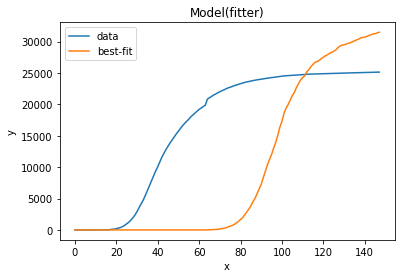

In [42]:
result.plot_fit(datafmt="-");